In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import dataset (Amazon Reviews)

In [2]:
reviews = pd.read_csv("../datasets/Reviews.csv")
reviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Data preprocessing

In [3]:
reviews = reviews[["Text", "Score"]]

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
 1   Score   568454 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [5]:
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [6]:
scores = list(np.unique(reviews.Score.values))
scores_counts = reviews.Score.value_counts().sort_index()

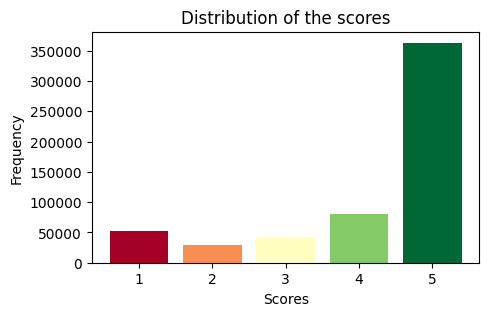

In [7]:
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(scores)))

plt.figure(figsize=(5,3))
plt.bar(scores, scores_counts, color = colors)
plt.title('Distribution of the scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()

In [8]:
sentiments = {
    1:'negative',
    2:'negative',
    3:'neutral',
    4:'positive',
    5:'positive'
}

sentiments

{1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'}

In [9]:
reviews['Sentiment'] = reviews['Score'].map(sentiments)

In [10]:
reviews.head()

,Text,Score,Sentiment
0,I have bought several of the Vitality canned d...,5,positive
1,Product arrived labeled as Jumbo Salted Peanut...,1,negative
2,This is a confection that has been around a fe...,4,positive
3,If you are looking for the secret ingredient i...,2,negative
4,Great taffy at a great price. There was a wid...,5,positive


In [11]:
senti= list(np.unique(reviews.Sentiment.values))
senti_counts = reviews.Sentiment.value_counts().sort_index()

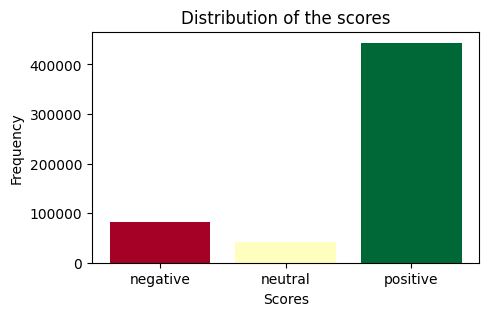

In [12]:
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(senti)))

plt.figure(figsize=(5,3))
plt.bar(senti, senti_counts, color = colors)
plt.title('Distribution of the scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()

We observe a significant imbalance between the classes, which is why we will proceed with "***undersampling***". This will allow us to balance the classes by ensuring that each class has the minimum number of observations. This operation applies only to the training set; the test set remains unbalanced to reflect reality.

In [13]:
from sklearn.model_selection import train_test_split

reviews_train, reviews_test = train_test_split(reviews, test_size=0.25, random_state=18, stratify=reviews["Sentiment"])

In [14]:
min_class_size = reviews_train.Sentiment.value_counts().min()
min_class_size

np.int64(31980)

In [15]:
reviews_train = reviews_train.groupby("Sentiment").sample(n=min_class_size, random_state=42).reset_index(drop=True)

In [16]:
senti= list(np.unique(reviews_train.Sentiment.values))
senti_counts = reviews_train.Sentiment.value_counts().sort_index()

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    reviews_train["Text"], reviews_train["Sentiment"], train_size=15000, test_size=2000, stratify=reviews_train["Sentiment"], random_state=42
)

X_test, _, y_test, _ = train_test_split(
    reviews_test["Text"], reviews_test["Sentiment"], train_size=5000, stratify=reviews_test["Sentiment"], random_state=42
)

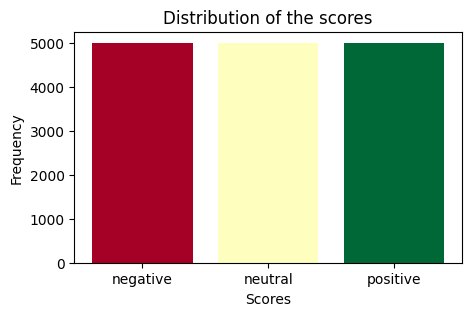

In [56]:
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(senti)))

plt.figure(figsize=(5,3))
plt.bar(senti, y_train.value_counts().sort_index(), color = colors)
plt.title('Distribution of the scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()

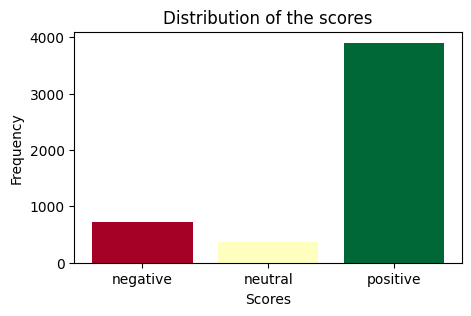

In [57]:
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(senti)))

plt.figure(figsize=(5,3))
plt.bar(senti, y_test.value_counts().sort_index(), color = colors)
plt.title('Distribution of the scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()

# Rule-based approach

We use ***SentiWordNet***,  a dictionary that assigns sentiment ***polarity scores*** to words. Our rule-based pipeline, implemented with the NLTK library, consists of the following steps:

- **Tokenization**: Breaking down the text into individual words
- **Lemmatization**: Reducing words to their base form (e.g., "running" → "run")
- **Stopword removal**: Filtering out common words without sentiment value (e.g., "the", "is", "a")
- **POS tagging**: Identifying the grammatical role of each word to retrieve the correct synset
- **Score aggregation**: Summing positive and negative scores from SentiWordNet
- **Classification**: Determining sentiment based on threshold values

In [46]:
from tqdm.auto import tqdm
tqdm.pandas() # to be able to use the "progress_apply"

from src.models.SentiWordNet import text_processing, sentiwordnet_scores, swn_predict_sentiment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
print(f"The text :\n{reviews.iloc[84].Text}")
print(f"The label :\n{reviews.iloc[84].Sentiment}")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
The text :
Awesome dog food. However, when given to my "Boston", who has severe reactions to some food ingredients; his itching increased to violent jumping out of bed at night, scratching. As soon as I changed to a different formula, the scratching stopped. So glad Natural Balance has other choices. I guess you have to try each, until you find what's best for your pet.
The label :
neutral


In [48]:
pos_tags = text_processing(reviews.iloc[84]["Text"], verbose=True)
positive_sentiment, negative_sentiment = sentiwordnet_scores(pos_tags)
print(f"Positivity score : {positive_sentiment} | Negativity score : {negative_sentiment}")

Tokenization...
Lemmatization...
POS tagging...
Positivity score : 3.125 | Negativity score : 3.375


In [49]:
score_diff = positive_sentiment - negative_sentiment

if score_diff > 0.25:
    print("The sentiment of the text is positive.")
elif score_diff < -0.25:
    print("The sentiment of the text is negative.")
else:
    print("The sentiment of the text is neutral.")

The sentiment of the text is neutral.


Let's predict the sentiments of the test set. We use ***tqdm*** to display a progress bar during the loop.

In [52]:
y_pred_swn = X_test.progress_apply(swn_predict_sentiment)

  0%|          | 0/5000 [00:00<?, ?it/s]

<!-- Since processing all ***568K reviews*** is too heavy, we randomly select a sample of ***1000 reviews*** and predict their sentiment. -->

Evaluating the quality of the predictions

In [61]:
from sklearn.metrics import balanced_accuracy_score, classification_report

print(f"Balanced accuracy (SentiWordNet) : {balanced_accuracy_score(y_test, y_pred_swn):.4f}")

Balanced accuracy (SentiWordNet) : 0.4700


In [54]:
print("Classification Report (SentiWordNet):\n")
print(classification_report(y_test, y_pred_swn))

Classification Report (SentiWordNet):



              precision    recall  f1-score   support

    negative       0.39      0.43      0.41       722
     neutral       0.09      0.34      0.15       375
    positive       0.88      0.63      0.74      3903

    accuracy                           0.58      5000
   macro avg       0.45      0.47      0.43      5000
weighted avg       0.75      0.58      0.65      5000



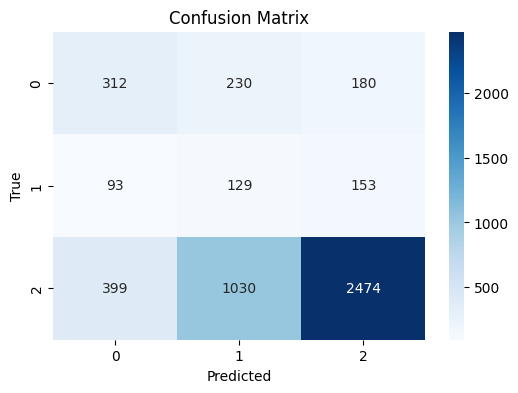

In [55]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_swn)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

We observe that the ***SentiWordNet-based*** function, which relies on ***rule-based*** lexical scoring, performs ***poorly*** in sentiment classification.

The confusion matrix shows that it predicts reviews as positive or neutral in most cases, even when they aren’t. This highlights a ***common issue*** with rule-based methods : they do not capture contextual information, especially things like negation, which often leads to wrong predictions.

<!-- Moreover, the method is computationally expensive. Processing and predicting sentiment for all ***$568K$*** reviews takes a considerable amount of time (~1 hour). -->

# Machine learning approach

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

In [63]:
import warnings
warnings.filterwarnings(action="ignore")

### Word embeddings

In [64]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", 
                                 #   max_features=5000,
                                   min_df=5)

In [65]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [66]:
X_train_tfidf.shape

(15000, 7482)

In [67]:
model_logistic = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)

model_rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model_gb = lgb.LGBMClassifier(
    n_estimators=250,
    num_leaves=50,
    learning_rate=0.1,
    class_weight='balanced',
    force_col_wise=True,    
    random_state=42,
    verbosity = -1
)

mlp = MLPClassifier(
    hidden_layer_sizes=(512, 128),
    max_iter=500,
    early_stopping=True,
    random_state=42        
)

In [68]:
print("Logistic Regression...")
model_logistic.fit(X_train_tfidf, y_train)

Logistic Regression...


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [69]:
print("Random Forest...")
model_rf.fit(X_train_tfidf, y_train, )

Random Forest...


RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=250,
                       n_jobs=-1, random_state=42)

In [70]:
print("Gradient Boosting (LightGBM)...")
model_gb.fit(X_train_tfidf, y_train)

Gradient Boosting (LightGBM)...


LGBMClassifier(class_weight='balanced', force_col_wise=True, n_estimators=250,
               num_leaves=50, random_state=42, verbosity=-1)

In [71]:
print("MLPClassifier (MLP)...")
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_encoded = y_train.map(label_map)
mlp.fit(X_train_tfidf, y_train_encoded)

MLPClassifier (MLP)...


MLPClassifier(early_stopping=True, hidden_layer_sizes=(512, 128), max_iter=500,
              random_state=42)

In [72]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_test_encoded = y_test.map(label_map)

In [73]:
y_pred_logistic = model_logistic.predict(X_test_tfidf)
y_pred_rf = model_rf.predict(X_test_tfidf)
y_pred_gb = model_gb.predict(X_test_tfidf)
y_pred_mlp = mlp.predict(X_test_tfidf)
inverse_label = {v: k for k, v in label_map.items()}
y_pred_mlp = [inverse_label[val] for val in y_pred_mlp]

In [74]:
print(f"Balanced accuracy (Logistic Regression) : {balanced_accuracy_score(y_test, y_pred_logistic):.4f}")
print(f"Balanced accuracy (Random Forest) : {balanced_accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Balanced accuracy (Gradient Boosting) : {balanced_accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Balanced accuracy (MLPClassifier) : {balanced_accuracy_score(y_test, y_pred_mlp):.4f}")

Balanced accuracy (Logistic Regression) : 0.6724
Balanced accuracy (Random Forest) : 0.6606
Balanced accuracy (Gradient Boosting) : 0.6613
Balanced accuracy (MLPClassifier) : 0.6746


**Best Performance**: MLPClassifier with Balanced Accuracy = 0.67 (+43% vs SentiWordNet)

In [77]:
print("Classification Report (MLPClassifier):\n")
print(classification_report(y_test, y_pred_mlp))

Classification Report (MLPClassifier):

              precision    recall  f1-score   support

    negative       0.60      0.68      0.64       722
     neutral       0.20      0.58      0.30       375
    positive       0.96      0.76      0.85      3903

    accuracy                           0.74      5000
   macro avg       0.59      0.67      0.60      5000
weighted avg       0.85      0.74      0.78      5000



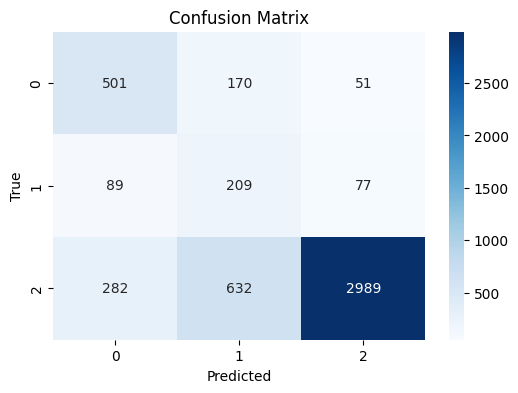

In [76]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Compared to the rule-based method, the ***Machine Learning*** approach proves to be significantly more efficient, boosting balanced accuracy from $47~\%$ to $67~\%$. Results could be further enhanced by adopting word embeddings other than the current ***TF-IDF***, which relies solely on word frequency across documents. This method overlooks critical aspects such as  : 
- Semantics
- Context
- Out-of-Vocabulary terms

Deep learning-based approaches, like ELMo (built on BiLSTM), offer a solution by effectively addressing these limitations.

# Transformer-based approach

In this part, we'll discover another types of embedding models, but this time based on the architecture of Transformers which lays on the ***Attention mechanism***.

In [21]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")    

print(device)

cpu


### BERT Embeddings

In [22]:
import warnings
warnings.filterwarnings(action="ignore")

In [23]:
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

We use ***RoBERTa***, an evolution of BERT. Since ***BERT*** models are built specifically on the ***Encoder stack*** of the Transformer architecture, they excel at ***capturing bidirectional context***, making them the industry standard for ***sentiment analysis*** tasks.

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL, framework ="pt")
model = AutoModel.from_pretrained(MODEL).to(device)

Transformer-based models require a fixed maximum sequence length, and this figure illustrates the distribution of tokenized sentence lengths in our dataset. We set `max_length = 128`, as it covers most sequences while keeping computation efficient.

  0%|          | 0/15000 [00:00<?, ?it/s]

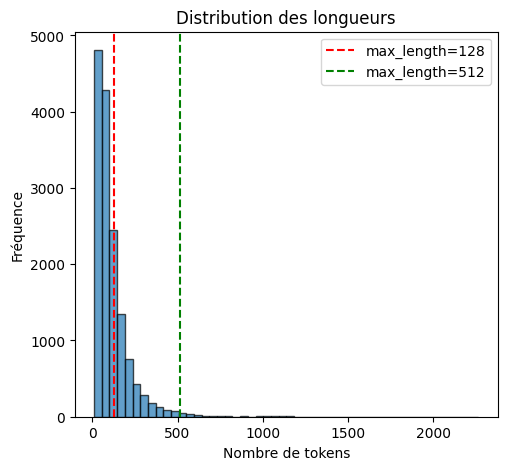

In [25]:
lengths = []
for text in tqdm(X_train.tolist()):
    tokens = tokenizer(str(text), truncation=False)
    lengths.append(len(tokens['input_ids']))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(128, color='r', linestyle='--', label='max_length=128')
plt.axvline(512, color='g', linestyle='--', label='max_length=512')
plt.xlabel('Nombre de tokens')
plt.ylabel('Fréquence')
plt.title('Distribution des longueurs')
plt.legend()
plt.show()

Sentence embeddings are obtained by mean-pooling the token representations from the last hidden layer of RoBERTa, ignoring padding tokens.

In [26]:
def mean_pooling(token_embeddings, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

In [27]:
def get_embeddings(texts, batch_size = 16):

    embeddings = []
    
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()    
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch, padding = True, truncation = True, max_length = 128, return_tensors = "pt")
            attention_mask = encoded['attention_mask']
            outputs = model(**encoded)            
            batch_emb = mean_pooling(outputs.last_hidden_state, attention_mask).numpy()
            embeddings.append(batch_emb)
    return np.vstack(embeddings)

In [28]:
X_train_transformers = get_embeddings(X_train)

  0%|          | 0/938 [00:00<?, ?it/s]

The UMAP projection shows that RoBERTa embeddings capture meaningful sentiment structure, with partial separation between positive, neutral, and negative samples.

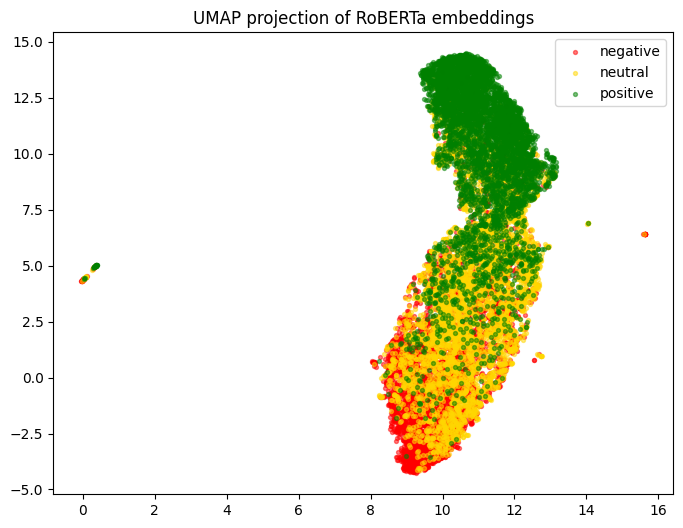

In [ ]:
import umap.umap_ as umap


labels = y_train.values

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
umap_res = umap_model.fit_transform(X_train_transformers)

plt.figure(figsize=(8, 6))

unique_labels = np.unique(labels)
colors = ["red", "gold", "green"]

for lab, col in zip(unique_labels, colors):
    idx = labels == lab
    plt.scatter(
        umap_res[idx, 0],
        umap_res[idx, 1],
        s=8,
        alpha=0.5,
        c=col,
        label=lab
    )

plt.title("UMAP projection of RoBERTa embeddings")
plt.legend()
plt.show()



In [29]:
X_test_transformers = get_embeddings(X_test)

  0%|          | 0/313 [00:00<?, ?it/s]

A machine learning classifier is trained on the extracted sentence embeddings to perform sentiment classification.

In [30]:
model_logistic_2 = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)

model_rf_2 = RandomForestClassifier(
    n_estimators=250,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model_gb_2 = lgb.LGBMClassifier(
    n_estimators=250,
    num_leaves=50,
    learning_rate=0.1,
    class_weight='balanced',
    force_col_wise=True,    
    random_state=42,
    verbosity = -1
)

mlp_2 = MLPClassifier(
    hidden_layer_sizes=(512, 128),
    max_iter=500,
    early_stopping=True,
    random_state=42        
)

In [31]:
print("Logistic Regression...")
model_logistic_2.fit(X_train_transformers, y_train)

Logistic Regression...


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [32]:
print("Random Forest...")
model_rf_2.fit(X_train_transformers, y_train, )

Random Forest...


RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=250,
                       n_jobs=-1, random_state=42)

In [33]:
print("Gradient Boosting (LightGBM)...")
model_gb_2.fit(X_train_transformers, y_train)

Gradient Boosting (LightGBM)...


LGBMClassifier(class_weight='balanced', force_col_wise=True, n_estimators=250,
               num_leaves=50, random_state=42, verbosity=-1)

In [34]:
print("MLPClassifier (MLP)...")
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_encoded = y_train.map(label_map)
mlp_2.fit(X_train_transformers, y_train_encoded)

MLPClassifier (MLP)...


MLPClassifier(early_stopping=True, hidden_layer_sizes=(512, 128), max_iter=500,
              random_state=42)

In [36]:
y_pred_logistic_2 = model_logistic_2.predict(X_test_transformers)
y_pred_rf_2 = model_rf_2.predict(X_test_transformers)
y_pred_gb_2 = model_gb_2.predict(X_test_transformers)
y_pred_mlp_2 = mlp_2.predict(X_test_transformers)
inverse_label = {v: k for k, v in label_map.items()}
y_pred_mlp_2 = [inverse_label[val] for val in y_pred_mlp_2]

In [59]:
print(f"Balanced accuracy (Logistic Regression) : {balanced_accuracy_score(y_test, y_pred_logistic_2):.4f}")
print(f"Balanced accuracy (Random Forest) : {balanced_accuracy_score(y_test, y_pred_rf_2):.4f}")
print(f"Balanced accuracy (Gradient Boosting) : {balanced_accuracy_score(y_test, y_pred_gb_2):.4f}")
print(f"Balanced accuracy (MLPClassifier) : {balanced_accuracy_score(y_test, y_pred_mlp_2):.4f}")

Balanced accuracy (Logistic Regression) : 0.7395
Balanced accuracy (Random Forest) : 0.7521
Balanced accuracy (Gradient Boosting) : 0.7518
Balanced accuracy (MLPClassifier) : 0.7477


**Best Performance**: Random Forest with Balanced Accuracy = 0.75 (+60% vs SentiWordNet, +12% vs TF-IDF)

In [78]:
print("Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_gb_2))

Classification Report (Random Forest):

              precision    recall  f1-score   support

    negative       0.71      0.78      0.75       722
     neutral       0.27      0.64      0.38       375
    positive       0.98      0.83      0.90      3903

    accuracy                           0.81      5000
   macro avg       0.65      0.75      0.68      5000
weighted avg       0.89      0.81      0.84      5000



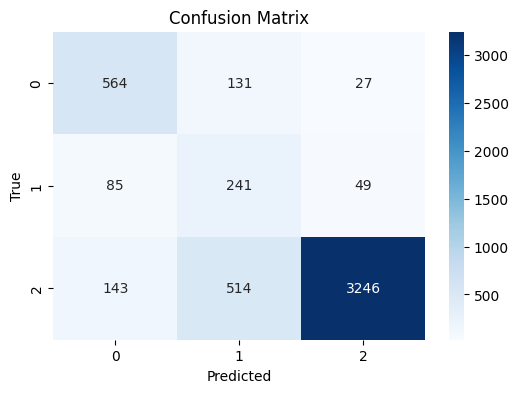

In [40]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_gb_2)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**RoBERTa** (pre-trained transformer) solves the three major TF-IDF limitations:
- **Semantics**: Captures similarity through dense vector space
- **Context**: Bidirectional encoding (attention mechanism) understands "not bad" as 
  a positive expression
- **OOV Handling**: Subword tokenization (BPE) manages neologisms and typos


# Saving models

In [43]:
import joblib

joblib.dump(model_gb_2, "../saved_models/model_lightgbm.pkl")

['../saved_models/model_lightgbm.pkl']

In [ ]:
tokenizer.save_pretrained("../saved_models/tokenizer")
model.save_pretrained("../saved_models/roberta_model")